# Forward dynamics of infection on Zachary’s karate club data
Comparison with Fig. 2 in *Ortega et. al*, [Dynamics of epidemics from cavity master equations: Susceptible-infectious-susceptible models](https://doi.org/10.1103/PhysRevE.105.024308)

In [79]:
getpid()

10273

In [77]:
using MatrixProductBP, MatrixProductBP.Models
using IndexedGraphs, DelimitedFiles, Plots, Statistics, LaTeXStrings
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
import Measurements: value
using Graphs
using JLD2;

In [2]:
# read matrix of contacts, found at http://konect.cc/networks/ucidata-zachary/
A = readdlm("karate.txt", Bool)
# gg = SimpleGraph(A)
# t = prim_mst(gg) |> SimpleGraph
# g = IndexedGraph(t);
g = IndexedGraph(A);
# seed = 1
# gg = erdos_renyi(34, 2.5/34; seed)
# g = IndexedGraph(gg);

In [73]:
N = nv(g)  # number of individuals
T = 50     # final time
ΔT = 2.0   # discretization
λ = 0.1    # prob. of transmission
ρ = 0.05   # prob. of recovery

# adjust probabilities and number of discrete time steps to simulate continuous-time behavior
sis = SIS(g, λ*ΔT, ρ*ΔT, floor(Int, T/ΔT))

# prob. of being infected at time zero
for i in 1:N
   if i == 1
        sis.ϕ[i][1] .= [0.0, 1.0]   # node 1 is infected at time zero
    else
        sis.ϕ[i][1] .= [1.0, 0.0]   # all other nodes start as susceptible
    end
end

# set up MPBP computation
bp = mpbp(sis)
cb = CB_BP(bp);

In [74]:
Tdisc = floor(Int, T/ΔT)
ϕ = [zeros(ne(bp.g)) for t in 0:Tdisc]
r = [zeros(nv(bp.g)) for t in 0:Tdisc]
r[1][1] = 1
for (i,j,id) in edges(g)
    ϕ[1][id] = r[1][i]*(1-r[1][j])
end

# dynamic message passing
function dmp_disc!(r, ϕ, Tdisc, g, λ, ρ)
    ProgressMeter.@showprogress for t in 2:Tdisc+1
        for i in vertices(g)
           r[t][i] = (1-ρ)*r[t-1][i] + 
                (1-prod(1-λ*ϕ[t-1][idx(e)] for e in inedges(g, i); init=1.0))*(1-r[t-1][i])
        end
        for (i, j, id) in edges(g)
           ϕ[t][id] = (1-ρ)*ϕ[t-1][id] + 
                (1-prod(1-λ*ϕ[t-1][idx(e)] for e in inedges(g, i) if src(e)!=j; init=1.0))*(1-ϕ[t-1][id])
        end
    end
    nothing
end
                
dmp_disc!(r, ϕ, Tdisc, bp.g, λ*ΔT, ρ*ΔT)
p_dmp = [[r[t][i] for t in eachindex(r)] for i in 1:N];

In [75]:
k = 8
svd_trunc = TruncBond(k)   # maximum matrix size for SVD-based truncation
maxiter = 100
tol = 1e-4

# run MPBP
reset!(bp)
iters, cb = iterate!(bp; cb, svd_trunc, maxiter, tol);

Running MPBP: iter 7 	 Time: 0:02:01
  Δ:                3.394036172712855e-5
  SVD Matrix size:  8

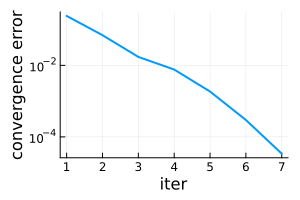

In [76]:
plot(cb.Δs, ylabel="convergence error", xlabel="iter", yaxis=:log10, 
    size=(300,200), label="")

In [67]:
# compute marginals
b_bp = beliefs(bp)
p_bp = [[bb[INFECTED] for bb in b] for b in b_bp]
p29_bp = [bb[INFECTED] for bb in b_bp[30]];

In [68]:
# instantiate Soft Margin sampler
sms = SoftMarginSampler(bp);

In [69]:
# draw samples
# re-run this cell (but not the one above!) to draw more samples and refine the estimate
nsamples_mc = 10^5
sample!(sms, nsamples_mc);

SoftMargin sampling 100%|████████████████████████████████| Time: 0:00:22m


In [70]:
b_mc = marginals(sms)
p_mc = [[bb[INFECTED]/sum(bb) for bb in b] for b in b_mc]
p29_mc = [bb[INFECTED]/sum(bb) for bb in b_mc[30]];

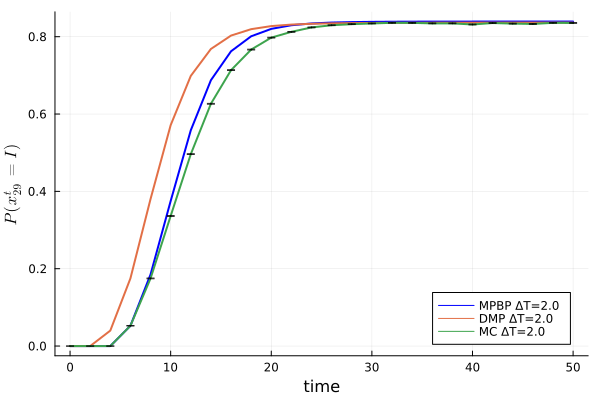

In [71]:
Plots.default(lw=2)
i = 30

pl = plot(xlabel="time", xticks=0:10:T, ylabel=L"P(x_{29}^t=I)", legend=:bottomright)
plot!(pl, 0:ΔT:T, p_bp[i], label="MPBP ΔT=$(ΔT)", c=:blue)
plot!(pl, 0:ΔT:T, p_dmp[i], label="DMP ΔT=$(ΔT)")
plot!(pl, 0:ΔT:T, p_mc[i], label="MC ΔT=$(ΔT)")

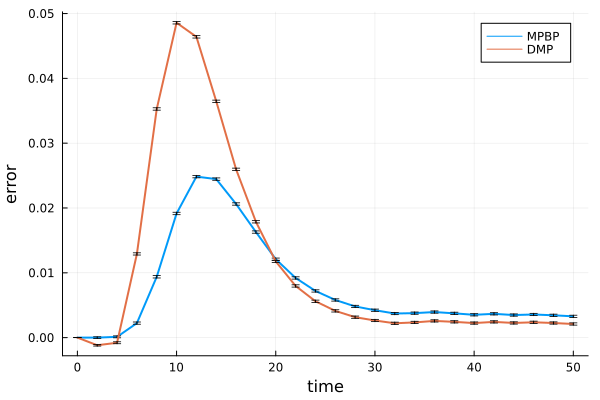

In [72]:
err_bp = mean(p_bp .- p_mc)
err_dmp = mean(p_dmp .- p_mc)
pl_err = plot(xlabel="time", ylabel="error", xticks=0:10:T)
plot!(pl_err, 0:ΔT:T, err_bp, label="MPBP")
plot!(pl_err, 0:ΔT:T, err_dmp, label="DMP")

In [33]:
Tnew = 5

# adjust probabilities and number of discrete time steps to simulate continuous-time behavior
sis = SIS(g, λ*ΔT, ρ*ΔT, floor(Int, Tnew/ΔT))

# prob. of being infected at time zero
for i in 1:N
   if i == 1
        sis.ϕ[i][1] .= [0.0, 1.0]   # node 1 is infected at time zero
    else
        sis.ϕ[i][1] .= [1.0, 0.0]   # all other nodes start as susceptible
    end
end

bp_trimmed = mpbp(sis)

p_hard = [1.0, 0.0]
for i in 1:N
    bp_trimmed.ϕ[i][end] .= p_hard
end
cb_trimmed = CB_BP(bp_trimmed);

In [34]:
svd_trunc = TruncBond(k)   # maximum matrix size for SVD-based truncation
maxiter = 50
tol = 1e-6

# run MPBP
iters, cb_trimmed = iterate!(bp_trimmed; cb=cb_trimmed, svd_trunc, maxiter, tol, damp=0.2);

Running MPBP: iter 9 	 Time: 0:00:23
  Δ:                7.911167262931055e-7
  SVD Matrix size:  10

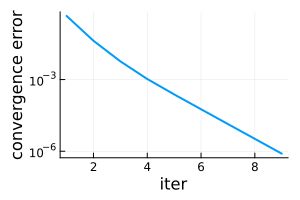

In [35]:
plot(cb_trimmed.Δs, ylabel="convergence error", xlabel="iter", yaxis=:log10, 
    size=(300,200), label="")

In [36]:
# compute marginals
@show p_dead_epidemic = exp(-bethe_free_energy(bp_trimmed))
b_constrained_ = beliefs(bp_trimmed)
b_constrained = map(1:N) do i
    map(eachindex(p29_bp)) do t
        if t <= floor(Int, Tnew/ΔT)
            b_constrained_[i][t]
        else
            [1.0, 0.0]
        end
    end
end
b_bp_trimmed = b_bp - b_constrained*p_dead_epidemic
p_bp_trimmed = [[bb[INFECTED]/sum(bb) for bb in b] for b in b_bp_trimmed]
p29_bp_trimmed = [bb[INFECTED]/sum(bb) for bb in b_bp_trimmed[30]];

p_dead_epidemic = exp(-(bethe_free_energy(bp_trimmed))) = 0.013443740947780017


In [59]:
# cavity master equation
function cme!(r, ϕ, Tdisc, g, λ, ρ)
    ProgressMeter.@showprogress for t in 2:Tdisc+1
        for i in vertices(g)
           r[t][i] = (1-ρ)*r[t-1][i] + λ*(1-r[t-1][i])*sum(ϕ[t-1][idx(e)] for e in inedges(g, i); init=0.0)
        end
        for (i, j, id) in edges(g)
           ϕ[t][id] = (1-ρ)*ϕ[t-1][id] + 
                (1-ϕ[t-1][id])*λ*sum(ϕ[t-1][idx(e)] for e in inedges(g, i) if src(e)!=j; init=0.0)
        end
    end
    nothing
end

# dynamic message passing
function dmp!(r, ϕ, Tdisc, g, λ, ρ)
    ProgressMeter.@showprogress for t in 2:Tdisc+1
        for i in vertices(g)
           r[t][i] = (1-ρ)*r[t-1][i] + λ*(1-r[t-1][i])sum(ϕ[t-1][idx(e)] for e in inedges(g, i); init=0.0)
        end
        for (i, j, id) in edges(g)
           ϕ[t][id] = (1-ρ)*ϕ[t-1][id] + 
                (1-r[t-1][i])*λ*sum(ϕ[t-1][idx(e)] for e in inedges(g, i) if src(e)!=j; init=0.0)
        end
    end
    nothing
end

# individual based mean field
function ibmf!(r, Tdisc, g, λ, ρ)
    ProgressMeter.@showprogress for t in 2:Tdisc+1
        for i in vertices(g)
           r[t][i] = (1-ρ)*r[t-1][i] + λ*(1-r[t-1][i])sum(r[t-1][src(e)] for e in inedges(g, i); init=0.0)
        end
    end
    nothing
end

ibmf! (generic function with 1 method)

In [60]:
Δt = 1e-4
Tdisc = floor(Int, T/Δt)

ϕ = [zeros(ne(bp.g)) for t in 0:Tdisc]
r = [zeros(nv(bp.g)) for t in 0:Tdisc]

r[1][1] = 1

for (i,j,id) in edges(g)
    ϕ[1][id] = r[1][i]*(1-r[1][j])
end

In [61]:
r_cme = deepcopy(r)
ϕ_cme = deepcopy(ϕ)
cme!(r_cme, ϕ_cme, Tdisc, bp.g, λ*Δt, ρ*Δt)
p_cme = [[rt[i] for rt in r_cme] for i in 1:N];

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


In [62]:
r_dmp = deepcopy(r)
ϕ_dmp = deepcopy(ϕ)
dmp!(r_dmp, ϕ_dmp, Tdisc, bp.g, λ*Δt, ρ*Δt)
p_dmp = [[rt[i] for rt in r_dmp] for i in 1:N];

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


In [63]:
r_ibmf = deepcopy(r)
ibmf!(r_ibmf, Tdisc, bp.g, λ*Δt, ρ*Δt)
p_ibmf = [[rt[i] for rt in r_ibmf] for i in 1:N];

Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


In [79]:
i = 1:N
nT = 50
Δtplot = T/nT
p_gill,_ = continuous_sis_sampler(sis, T, λ, ρ; nsamples = 10^5, sites=i, Δt=Δtplot,
    discard_dead_epidemics=false)
p_gill_trimmed,_ = continuous_sis_sampler(sis, T, λ, ρ; nsamples = 10^5, sites=i, Δt=Δtplot,
    discard_dead_epidemics=true);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


In [81]:
p_gill = [continuous_sis_sampler(sis, T, λ, ρ; nsamples = 10^5, sites=i, Δt=Δtplot,
    discard_dead_epidemics=false)[1] for i in 1:N];

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 

In [43]:
# instantiate Soft Margin sampler
sms = SoftMarginSampler(bp);

In [44]:
# draw samples
# re-run this cell (but not the one above!) to draw more samples and refine the estimate
nsamples_mc = 10^5
sample!(sms, nsamples_mc);

SoftMargin sampling 100%|████████████████████████████████| Time: 0:00:45m


In [45]:
b_mc = marginals(sms)
p_mc = [[bb[INFECTED]/sum(bb) for bb in b] for b in b_mc]
p29_mc = [bb[INFECTED]/sum(bb) for bb in b_mc[30]];

In [46]:
# # discard monte carlo runs with no infected at final time
# # this is to compare with the results in the paper
ids = findall(!all(x[:,10] .== SUSCEPTIBLE) for x in sms.X)
Xnew = sms.X[ids]
wnew = sms.w[ids]
sms_new = SoftMarginSampler(bp, Xnew, wnew)
b_mc_trimmed = marginals(sms_new)
p_mc_trimmed = [[bb[INFECTED]/sum(bb) for bb in b] for b in b_mc_trimmed]
p29_mc_trimmed = [bb[INFECTED]/sum(bb) for bb in b_mc_trimmed[30]];

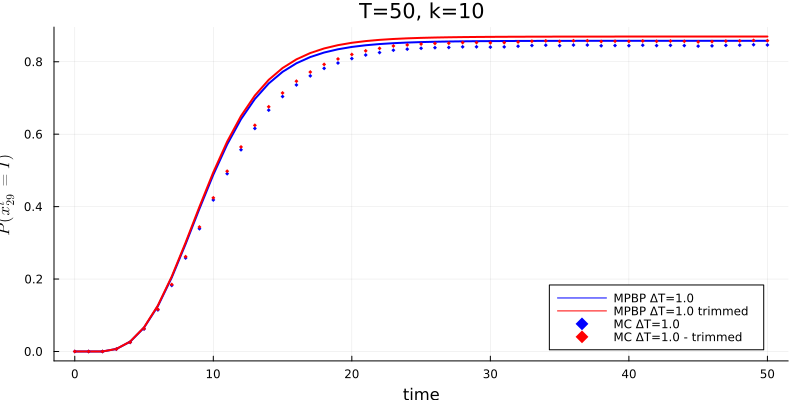

In [47]:
Plots.default(lw=2)
i = 30

pl = plot(xlabel="time", xticks=0:10:T, ylabel=L"P(x_{29}^t=I)", legend=:bottomright)
plot!(pl, 0:ΔT:T, p_bp[i], label="MPBP ΔT=$(ΔT)", c=:blue)
plot!(pl, 0:ΔT:T, p_bp_trimmed[i], label="MPBP ΔT=$(ΔT) trimmed", c=:red)
# plot!(pl, 0:Δt*nT:T, p_dmp[30][1:nT:end], ls=:dash, label="rDMP Δt=$(Δt)")
# plot!(pl, 0:Δt*nT:T, p_cme[30][1:nT:end], ls=:dashdot, label="CME Δt=$(Δt)")
# plot!(pl, 0:Δt*nT:T, p_ibmf[30][1:nT:end], ls=:dashdotdot, label="IBMF Δt=$(Δt)")
# plot!(pl, 0:Δt:T, p_pbmf1[30], ls=:dashdotdot, label="PBMF1")
scatter!(pl, 0:ΔT:T, value.(p_mc[i]), m=:diamond, ms=2, label="MC ΔT=$(ΔT)", c=:blue, msc=:auto)
scatter!(pl, 0:ΔT:T, value.(p_mc_trimmed[i]), m=:diamond, ms=2, label="MC ΔT=$(ΔT) - trimmed", c=:red, 
    msc=:auto)
plot!(pl, size=(800,400), title="T=$T, k=$k")
# plot!(pl, 0:Δtplot:T, p_gill, label="Gillespie", m=:diamond, c=:green, st=:scatter, ms=1.5, msc=:auto)
# plot!(pl, 0:Δtplot:T, p_gill_trimmed, label="Gillespie trimmed", m=:diamond, c=:magenta, st=:scatter, ms=1.5, msc=:auto)
# plot!(pl, size=(1000,400), margin=5Plots.mm, legend=:bottomright)

# ylims = (0.85,0.88)
# plot!(pl, xticks=T-5:1:T, ylims=ylims, xlims=(T-5,T),
#     inset=(1, bbox(0.5, 0.25, 0.45, 0.3)), subplot=2)
# plot!(pl[2], 0:ΔT:T, p29_bp, label="")
# plot!(pl[2], 0:Δt:T, p_dmp[30], ls=:dash, label="")
# plot!(pl[2], 0:Δt:T, p_cme[30], ls=:dashdot, label="")
# plot!(pl[2], 0:Δt:T, p_ibmf[30], ls=:dashdotdot, label="")
# scatter!(pl[2], 0:Δt:T, value.(p29_mc), m=:diamond, ms=3, label="", c=:black);

In [69]:
T/Δt

500000.0

In [67]:
length(p_cme[1]), length(p_mc[1])

(500001, 51)

In [75]:
err_bp = [mean(abs(p_bp[i][t]-p_mc[i][t]) for i in 1:N) for t in eachindex(p_bp[1])]
err_cme = [mean(abs(p_cme[i][1:Int(1/Δt):end][t]-p_mc[i][t]) for i in 1:N) for t in eachindex(p_bp[1])]
err_dmp = [mean(abs(p_dmp[i][1:Int(1/Δt):end][t]-p_mc[i][t]) for i in 1:N) for t in eachindex(p_bp[1])]
err_ibmf = [mean(abs(p_ibmf[i][1:Int(1/Δt):end][t]-p_mc[i][t]) for i in 1:N) for t in eachindex(p_bp[1])];

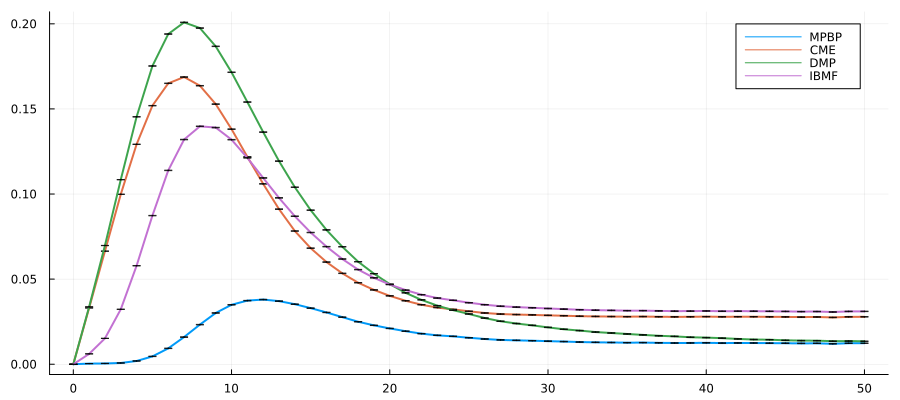

In [78]:
plot(0:ΔT:T, err_bp, label="MPBP")
plot!(0:ΔT:T, err_cme, label="CME")
plot!(0:ΔT:T, err_dmp, label="DMP")
plot!(0:ΔT:T, err_ibmf, label="IBMF")
plot!(size=(900,400))

In [82]:
err_bp = [mean(abs(p_bp[i][1:Int(1/\DeltaT):end][t]-p_gill[i][t]) for i in 1:N) for t in eachindex(p_bp[1])]
err_cme = [mean(abs(p_cme[i][1:Int(1/Δt):end][t]-p_gill[i][t]) for i in 1:N) for t in eachindex(p_bp[1])]
err_dmp = [mean(abs(p_dmp[i][1:Int(1/Δt):end][t]-p_gill[i][t]) for i in 1:N) for t in eachindex(p_bp[1])]
err_ibmf = [mean(abs(p_ibmf[i][1:Int(1/Δt):end][t]-p_gill[i][t]) for i in 1:N) for t in eachindex(p_bp[1])];

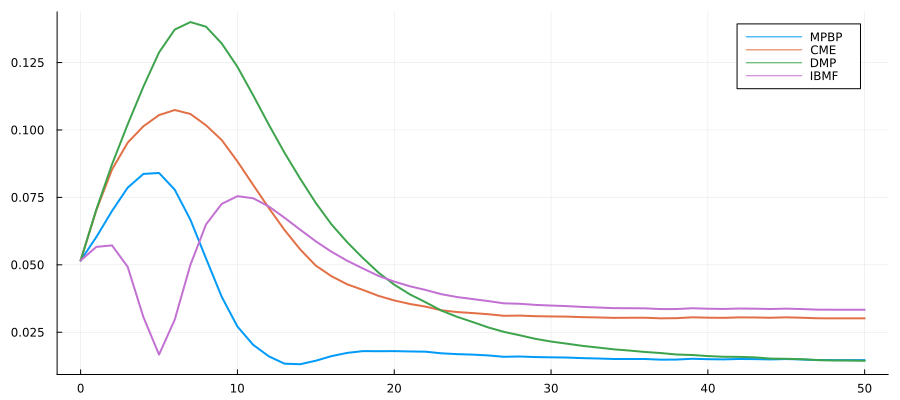

In [83]:
plot(0:ΔT:T, err_bp, label="MPBP")
plot!(0:ΔT:T, err_cme, label="CME")
plot!(0:ΔT:T, err_dmp, label="DMP")
plot!(0:ΔT:T, err_ibmf, label="IBMF")
plot!(size=(900,400))

In [48]:
savefig(pl, "karate7.pdf")

"/home/crotti/MatrixProductBP/notebooks/karate7.pdf"

In [49]:
# c_bp = autocovariances(bp);

In [50]:
# using ColorSchemes
# function plot_autocovs(c, T; ΔT=1.0, kw...)
#     us = 0:5:T
#     cg = cgrad(:matter, length(us), categorical=true)
#     ylabel = L"\langle x_{29}^t x_{29}^{t+\Delta t}\rangle-" * 
#         L"\langle x_{29}^t\rangle\langle x_{29}^{t+\Delta t}\rangle"
#     xlabel = L"\Delta t"
#     pl = plot(;xlabel, ylabel, legend=:outertopright, 
#         title="SIS karate club. λ = $λ, ρ = $ρ")
     
#     for (j,u) in enumerate(us)
#         plot!(pl, (u:-1:1).*ΔT, c[(0:u-1) .+ 1,u+1], label="t+Δt=$(Int(u*ΔT))", c=cg[j], m=:o, msc=cg[j]; kw...) 
#     end
#     pl
# end  

In [51]:
# c_bp29 = map(x -> x > 1e-14 ? x : NaN, c_bp[30])
# pl_autocov = plot_autocovs(c_bp29, floor(Int, T/ΔT); ΔT, yaxis=(:log10), 
#     size=(900,400), margin=5Plots.mm)

In [52]:
# jldsave("plot_data/sis_karate_club_network.jld2"; T, ΔT, Δt, p_bp, p_mc, p_dmp, p_cme, p_ibmf, c_bp,
#     λ, ρ, svd_trunc);